# Analysis of Processed and Filtered Data

**Imports**

In [1]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
from disaster_extr_constants import *
from disaster_extr_helpers import df_time_interval
from sklearn import preprocessing

In [2]:
def extract_disaster(year,disaster_type, general=False):
    # General --> consider whole year datasets (not the specific disasters)
    if general:  
        disaster_path = 'data/'+str(year)+'_'+disaster_type+'_whole_year_csv.bz2'
        disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
        disaster_df_2 = None
        
        climate_path = 'data/'+str(year)+'_climate_whole_year_csv.bz2'
        climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')

        start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
    
    else:
        if year == 2018 and disaster_type == 'storm':
            disaster_path_asia = 'data/'+str(year)+'_'+disaster_type+'_filtered_asia_csv.bz2'
            disaster_path_america = 'data/'+str(year)+'_'+disaster_type+'_filtered_america_csv.bz2'

            disaster_df = pd.read_csv(disaster_path_asia, parse_dates = ['date'], compression='bz2')
            disaster_df_2 = pd.read_csv(disaster_path_america, parse_dates = ['date'], compression='bz2')

        else:
            disaster_path = 'data/'+str(year)+'_'+disaster_type+'_filtered_csv.bz2'
            disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
            disaster_df_2 = None

        climate_path = 'data/'+str(year)+'_'+disaster_type+'_climate_filtered_csv.bz2'
        climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')

        start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
    
        if year == 2018 and disaster_type == 'storm':
            start_disaster_2, end_disaster_2 = disaster_df_2.date.min(), disaster_df_2.date.max()

            start_disaster = min([start_disaster,start_disaster_2])
            end_disaster = min([end_disaster,end_disaster_2])
    
    start_climate, end_climate = climate_df.date.min(), climate_df.date.max()
    
    return (climate_df, start_climate, end_climate), (disaster_df, start_disaster, end_disaster), disaster_df_2

In [3]:
def create_hist_comparison(year,disaster_type,general=False):
        
    all_data = extract_disaster(year,disaster_type,general)
    
    (climate_df, start_climate, end_climate) = all_data[0]
    (disaster_df, start_disaster, end_disaster) = all_data[1]
    disaster_df_2 = all_data[2]
    
    if disaster_df_2:
        dscr_str = 'Asia'
        dscr_str_2 = 'America'
    else:
        dscr_str = ''
    
    print("Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print("Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + ' Storm ',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    
    _, bins, _ = plt.hist(
        climate_df.date, 
        bins=60, 
        weights=climate_df.numOccurrences,
        alpha=0.4,
        label='Climate Talk', 
        log=True)
    
    plt.hist(
        disaster_df.date, 
        bins=bins, 
        weights=disaster_df.numOccurrences,
        alpha=0.7,
        label=type_to_str[disaster_type]+dscr_str+' Talk')
    
    if disaster_df_2:
        plt.hist(
            disaster_df_2.date, 
            bins=bins, 
            weights=disaster_df_2.numOccurrences,
            alpha=0.3,
            label=type_to_str[disaster_type]+dscr_str_2+' Talk')
    
    plt.xlabel("Time")
    plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='upper left')
    plt.show()

In [4]:
def compute_relevant_spikes(specific_data, 
                            general_data, 
                            specific_general_increase=2.5,
                            specific_increase=0.1):
    # Compute time shifted versions of both input arrays
    shifted_specific = np.concatenate(([specific_data[0]],specific_data[:-1]))
    shifted_general = np.concatenate(([general_data[0]],general_data[:-1]))
    
    # Compute respective differences (to capture increases)
    specific_difference = specific_data - shifted_specific
    general_difference = general_data - shifted_general
    
    # Compute difference between increases in specific quotes (climate or disaster)
    # general quote (contains 'especially'). Possibility to use a factor
    # to raise the factor by white the specific increase must surpass the general increase
    increase_by_factor = specific_difference - general_difference * specific_general_increase
    
    # When (i.e., for a given time index) specific increase is 'specific_general_increase' 
    # times higher than the general increase and the specific increase is greater 
    # than 'specific_increase' return the corresponding entry from 'specific_data',
    # otherwise return 0
    
    out = np.where(((increase_by_factor > 0) & (specific_difference >= specific_increase)), 
                   specific_data, 0)
    return out

In [76]:
def create_plot_comparison(year,
                           disaster_type,
                           general=False,
                           resample=None, 
                           normalize=False, 
                           log=True, 
                           norm_additional=False,
                           drop_n_first=0,
                           drop_n_last=0,
                           save_fig=False):
        
    all_data = extract_disaster(year,disaster_type,general)
    
    (climate_df, start_climate, end_climate) = all_data[0]
    (disaster_df, start_disaster, end_disaster) = all_data[1]
    disaster_df_2 = all_data[2]
    
    if resample:
        climate_df.at[0, 'date'] = datetime.datetime(year, 1, 1)
        disaster_df.at[0, 'date'] = datetime.datetime(year, 1, 1)
        climate_df = climate_df.set_index('date').resample(resample).sum().dropna().reset_index()
        disaster_df = disaster_df.set_index('date').resample(resample).sum().dropna().reset_index()
        
        #if drop_first_and_last:
        climate_df.drop(climate_df.tail(drop_n_last).index,inplace=True)
        climate_df.drop(climate_df.head(drop_n_first).index,inplace=True)
        disaster_df.drop(disaster_df.tail(drop_n_last).index,inplace=True)
        disaster_df.drop(disaster_df.head(drop_n_first).index,inplace=True)
            
        if normalize:
            x_climate = climate_df.numOccurrences.values.reshape(-1, 1)
            min_max_scaler_climate = preprocessing.MinMaxScaler().fit(x_climate)
            x_climate_scaled = min_max_scaler_climate.transform(x_climate)
            
            x_disaster = disaster_df.numOccurrences.values.reshape(-1, 1)
            min_max_scaler_disaster = preprocessing.MinMaxScaler().fit(x_disaster)
            x_disaster_scaled = min_max_scaler_disaster.transform(x_disaster)
            
            climate_df.numOccurrences = pd.DataFrame(x_climate_scaled)
            disaster_df.numOccurrences = pd.DataFrame(x_disaster_scaled)
            
        if norm_additional:
            norm_path = 'data/'+str(year)+'_especially__csv.bz2'
            norm_df = pd.read_csv(norm_path, parse_dates = ['date'], compression='bz2')
            norm_df.at[0, 'date'] = datetime.datetime(year, 1, 1)

            norm_df = norm_df.set_index('date').resample(resample).sum().dropna().reset_index()
            
            #if drop_first_and_last:
            norm_df.drop(norm_df.tail(drop_n_last).index,inplace=True)
            norm_df.drop(norm_df.head(drop_n_first).index,inplace=True)
            
            if year == 2018:
                norm_df.at[norm_df.idxmax().numOccurrences, 'numOccurrences'] = norm_df.numOccurrences.mean()
            
            if normalize:
                x_norm = norm_df.numOccurrences.values.reshape(-1, 1)
                min_max_scaler = preprocessing.MinMaxScaler()
                x_norm_scaled = min_max_scaler.fit_transform(x_norm)
                norm_df.numOccurrences = pd.DataFrame(x_norm_scaled)
                
                
    if disaster_df_2 is not None:
        dscr_str = 'Asia'
        dscr_str_2 = 'America'
        if resample:
            disaster_df_2 = disaster_df_2.set_index('date').resample(resample).sum().dropna().reset_index()
            
            if normalize:
                x_disaster_2 = disaster_df_2.numOccurrences.values.reshape(-1, 1)
                min_max_scaler = preprocessing.MinMaxScaler()
                x_disaster_2_scaled = min_max_scaler.fit_transform(x_disaster_2)                
                disaster_df_2.numOccurrences = pd.DataFrame(x_disaster_2_scaled)
                
                    
    else:
        dscr_str = ''
    
    print("Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print("Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + ' Storm ',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    
    type_to_str = {
        'storm': 'Storm ',
        'heat_wave': 'Heat Wave ',
    }
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    plt.grid()
    
    plt.plot(
    climate_df.date,  
    climate_df.numOccurrences,
    alpha=0.4,
    label='Climate Talk',
    marker='o')
    
    plt.plot(
    disaster_df.date,  
    disaster_df.numOccurrences,
    alpha=0.7,
    label=type_to_str[disaster_type]+dscr_str+' Talk',
    marker='o')
    
    
    if norm_additional:
        plt.plot(
        norm_df.date,  
        norm_df.numOccurrences,
        alpha=0.3,
        label='Overall Quote Indicator',
        marker='o')
        
    if disaster_df_2 is not None:
        plt.plot(
        disaster_df_2.date,  
        disaster_df_2.numOccurrences,
        alpha=0.3,
        label=type_to_str[disaster_type]+dscr_str_2+' Talk',
        marker='o')
        
    if log:   
        plt.yscale('log')
    plt.xlabel("Time")
    plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='lower right')
    if save_fig:
        plt.savefig('images/'+str(year)+'_'+disaster_type+'.png', bbox_inches='tight')
    plt.show()

In [77]:
def create_normalized_comparison(year,
                                 disaster_type,
                                 resample='1W',
                                 drop_n_first=0,
                                 drop_n_last=0,
                                 specific_general_increase=2.5,
                                 specific_increase=0.1, 
                                 save_fig=False):
        
    all_data = extract_disaster(year,disaster_type,general=True)
    
    (climate_df, start_climate, end_climate) = all_data[0]
    (disaster_df, start_disaster, end_disaster) = all_data[1]
    disaster_df_2 = all_data[2]
    
    climate_df.at[0, 'date'] = datetime.datetime(year, 1, 1)
    disaster_df.at[0, 'date'] = datetime.datetime(year, 1, 1)
    climate_df = climate_df.set_index('date').resample(resample).sum().dropna().reset_index()
    disaster_df = disaster_df.set_index('date').resample(resample).sum().dropna().reset_index()
    
    climate_df.drop(climate_df.tail(drop_n_last).index,inplace=True)
    climate_df.drop(climate_df.head(drop_n_first).index,inplace=True)
    disaster_df.drop(disaster_df.tail(drop_n_last).index,inplace=True)
    disaster_df.drop(disaster_df.head(drop_n_first).index,inplace=True)

    x_climate = climate_df.numOccurrences.values.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_climate_scaled = min_max_scaler.fit_transform(x_climate)

    x_disaster = disaster_df.numOccurrences.values.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_disaster_scaled = min_max_scaler.fit_transform(x_disaster)
    
    climate_df.numOccurrences = pd.DataFrame(x_climate_scaled, index=climate_df.index)
    disaster_df.numOccurrences = pd.DataFrame(x_disaster_scaled, index=disaster_df.index)

    norm_path = 'data/'+str(year)+'_especially__csv.bz2'
    norm_df = pd.read_csv(norm_path, parse_dates = ['date'], compression='bz2')
    norm_df.at[0, 'date'] = datetime.datetime(year, 1, 1)

    norm_df = norm_df.set_index('date').resample(resample).sum().dropna().reset_index()
    
    norm_df.drop(norm_df.tail(drop_n_last).index,inplace=True)
    norm_df.drop(norm_df.head(drop_n_first).index,inplace=True)
    
    if year == 2018:
        norm_df.at[norm_df.idxmax().numOccurrences, 'numOccurrences'] = norm_df.numOccurrences.mean()

    x_norm = norm_df.numOccurrences.values.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_norm_scaled = min_max_scaler.fit_transform(x_norm)
    norm_df.numOccurrences = pd.DataFrame(x_norm_scaled, index=norm_df.index)

    climate_relevant_spikes = compute_relevant_spikes(x_climate_scaled.ravel(), 
                                                      x_norm_scaled.ravel(),
                                                      specific_general_increase,
                                                      specific_increase)
    disaster_relevant_spikes = compute_relevant_spikes(x_disaster_scaled.ravel(),
                                                       x_norm_scaled.ravel(),
                                                       specific_general_increase,
                                                       specific_increase)
    
    climate_df["spikes"] = pd.DataFrame(climate_relevant_spikes, index=climate_df.index)
    disaster_df["spikes"]  = pd.DataFrame(disaster_relevant_spikes, index=disaster_df.index)   
    
    if disaster_df_2 is not None:
        dscr_str = 'Asia'
        dscr_str_2 = 'America'
        if resample:
            disaster_df_2 = disaster_df_2.set_index('date').resample(resample).sum().dropna().reset_index()

            x_disaster_2 = disaster_df_2.numOccurrences.values.reshape(-1, 1)
            min_max_scaler = preprocessing.MinMaxScaler()
            x_disaster_2_scaled = min_max_scaler.fit_transform(x_disaster_2)

            x_disaster_2_scaled = compute_relevant_spikes(x_disaster_2_scaled.ravel(), x_norm_scaled.ravel())
            disaster_df_2.numOccurrences = pd.DataFrame(x_disaster_2_scaled)
                
                    
    else:
        dscr_str = ''
    
    print("Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print("Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + ' Storm ',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    type_to_str = {
        'storm': 'Storm ',
        'heat_wave': 'Heat Wave ',
    } 
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    plt.grid()

    p = plt.plot(climate_df.date,  
                 climate_df.numOccurrences,
                 alpha=0.7,
                 label='Climate Talk',
                 linestyle='--')
    
    climate_df = climate_df[climate_df.spikes > 0]
    
    plt.scatter(climate_df.date,  
                climate_df.spikes,
                alpha=1.0,
                color=p[0].get_color(),
                marker='o')
    
    #start, end = plt.xlim()
    #plt.xticks(climate_df.date[0::5])

    p = plt.plot(disaster_df.date,  
                 disaster_df.numOccurrences,
                 alpha=0.7,
                 #label=type_to_str[disaster_type]+dscr_str+' Talk',
                 label=type_to_str[disaster_type]+dscr_str+' Talk',
                 linestyle='--')
    
    disaster_df = disaster_df[disaster_df.spikes > 0]
    
    plt.scatter(disaster_df.date,  
                disaster_df.spikes,
                alpha=1.0,
                color=p[0].get_color(),
                marker='o')
    
    plt.plot(norm_df.date,  
             norm_df.numOccurrences,
             alpha=0.5,
             #label=str(year) + ' Overall Quote Indicator',
             label='Overall Quote Indicator',
             #marker='o'
             linestyle='--'
            )
    
    if disaster_df_2 is not None:
        plt.plot(
        disaster_df_2.date,  
        disaster_df_2.numOccurrences,
        alpha=0.3,
        label=type_to_str[disaster_type]+dscr_str_2+' Talk',
        marker='o')
        
    plt.xlabel("Time")
    plt.ylabel("Absolute Nº of Quotes (numOccurrences)")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='lower right')
    if save_fig:
        plt.savefig('images/'+str(year)+'_'+disaster_type+'_peaks.png', bbox_inches='tight')
    plt.show()

## Comparisons of Climate and Disaster Discussion

In these plots, a comparison is made between discussion around the topic of climate change and a general type of natural disaster, either storms (e.g., hurricanes, typhoons, ...) or heat waves. One can be tempted to conclude than an observed increase in both would mean that the natural disaster caused an increase in discussion around climate change, however many factors can come into play, such as climate summits and strikes. On a more technical level though, the overall amount of quotes in the Quotebank dataset can fluctuate over time, meaning that an observed increase in the quotes related to climate change might be due to an increase in the overall number of quotes retrieved during that time window, rather than being due to a 'real' increase in quotes in the real world. 

We attempt to account for this by picking a common english word ('especially') which is broad enough to appear in many different contexts but not so broad that a subset of the Quotebank dataset for a given year which contains this token is too big to load into memory. The idea is that this 'general' data is able to represent the general evolution of the number of quotes throughout a given time frame, in our case a year. We plot the evolution (binned into weekly intervals) of the three quantities: quotes related to climate change, a type of natural disaster, and our general token ('especially').

For certain years, we observe that the beginning and/or end has much fewer quotes than average. For these years, we 'clip' the time frame (anywhere between 1-5 weeks) so that most of the variation in the quote frequencies is accounted for by time windows that don't contain these 'artificial' drops or spikes due simply to an increase/decrease in quotes retrieved during Quotebank's development. Whenever such a 'clip' is performed, the before and after result (plot) is always displayed.

When plotting the evolution of the three quote sets, it can, for certain years, become blatantly obvious that spikes in the climate and disaster data happen simply because there is an increase in overall number of quotes because the 'general' data follows the exact same trend. The goal is to identify the parts of the climate and disaster data which increase for a reason other than there simply being a sudden increase in overall number of 'general' quotes.

In order to reach the aforementioned goal, we define a method for extracting so-called 'relevant spikes'. These are spikes in the climate and disaster related data which go against the 'natural' trend of the 'general' data. By 'going against' we mean that either of the climate or disaster data has a (factor adjustable) increase which is stronger than that of the 'general' data (if the latter increases at all, it might very well decrease). When performing these computations we have first min-max normalized each of the three time series in order to bring the fluctuations to the same scale. Regarding the 'relevant spikes' we also require that the increase itself is stronger than some input parameter between 0 and 1. This avoids identifying spikes simply due to a sharp decrease in the 'general' data.

The pairs of plots can be viewed below, each one corresponding to a given disaster type (either storm or heat wave) and year. The first plot in each pair compares the evolution of the weekly-binned quote occurrences. If any clipping is to be performed, a second plot is displayed resulting from this operation. The second (or therefore sometimes third) plot shows the evolution of the three normalized quote occurrences, with markers on either the disaster or climate data that represent the identified 'relevant spikes'. Observe how certain spikes in the climate and/or disaster data are not identified as 'relevant spikes' as a result of being nullified by similar pattern in the 'general' data.

In [79]:
save_fig = True

### Storms

**2015**

In [64]:
year = 2015
disaster_type = 'storm'

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


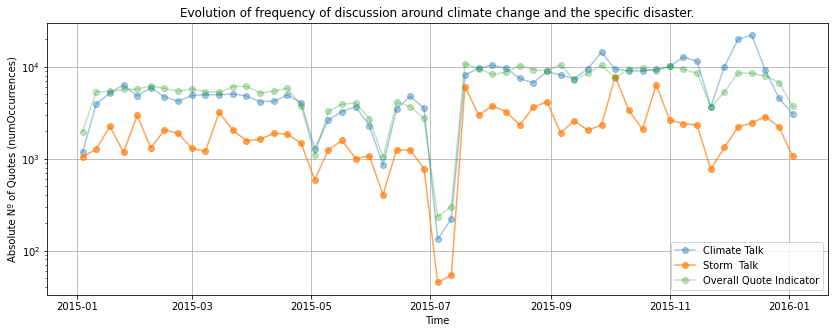

In [65]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       save_fig=save_fig)

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


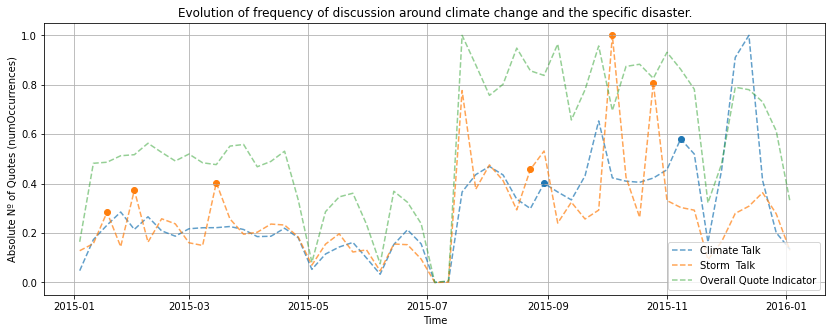

In [71]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W')

**2016**

In [10]:
year = 2016
disaster_type = 'storm'

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


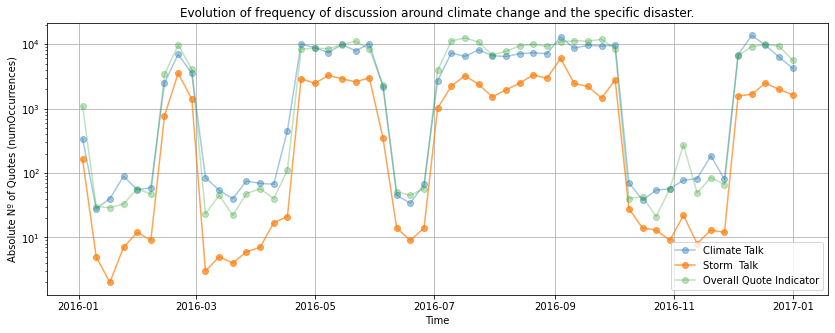

In [11]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       save_fig=save_fig)

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


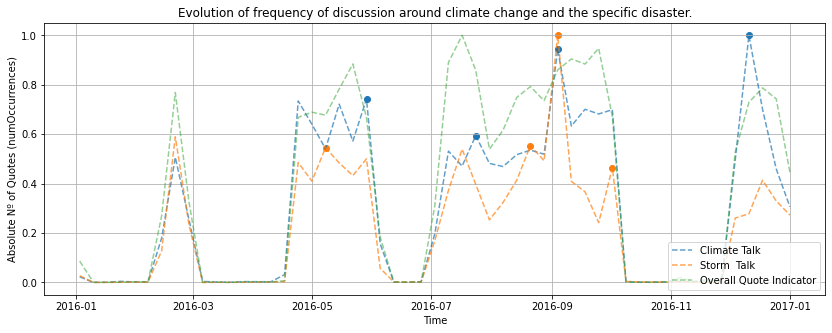

In [12]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             save_fig=save_fig)

**2017**

In [13]:
year = 2017
disaster_type = 'storm'
drop_n_first = 5
specific_general_increase = 1.2
specific_increase = 0.07

Disaster Dates: 2017-01-03 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


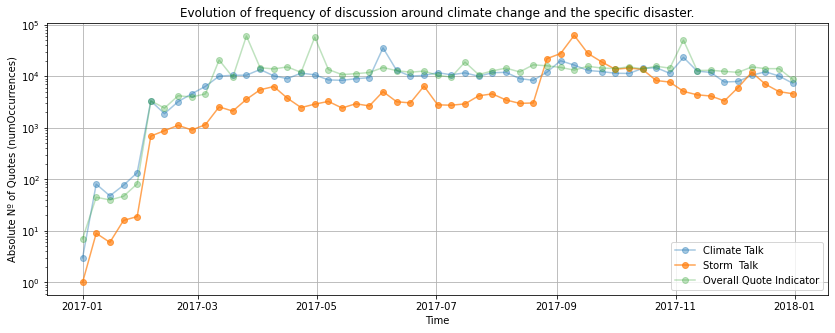

In [14]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       drop_n_first=0,
                       save_fig=save_fig)

Disaster Dates: 2017-01-03 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


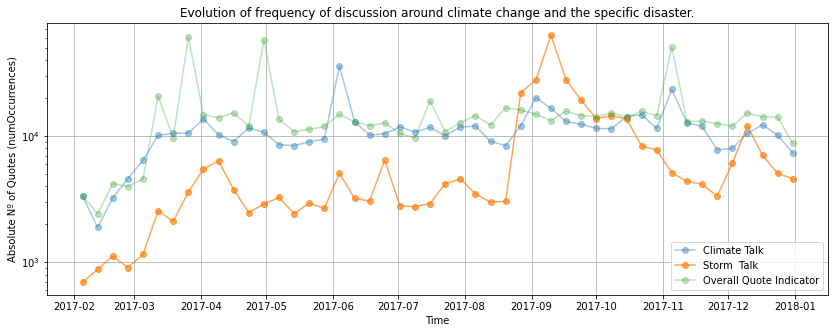

In [15]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       drop_n_first=drop_n_first,
                       save_fig=save_fig)

Disaster Dates: 2017-01-03 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


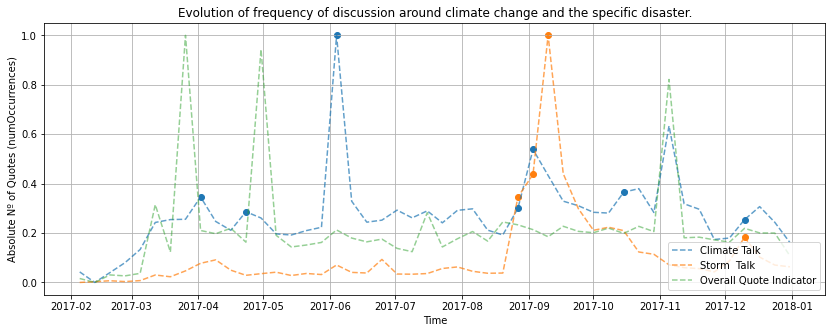

In [16]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             drop_n_first=drop_n_first,
                             specific_general_increase=specific_general_increase,
                             specific_increase=specific_increase,
                             save_fig=save_fig)

**2018**

In [17]:
year = 2018
disaster_type = 'storm'
drop_n_last = 1
specific_general_increase = 3.0
specific_increase = 0.05

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


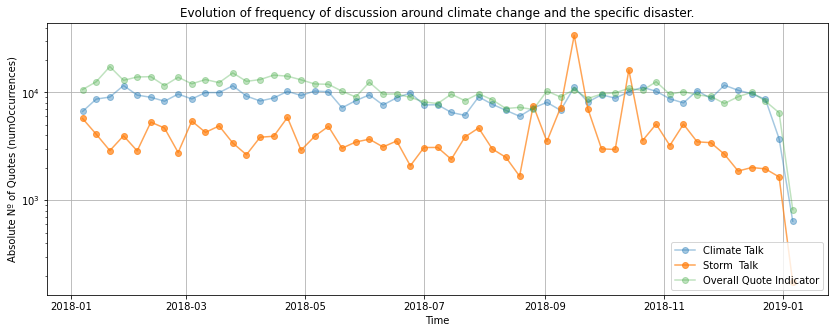

In [18]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W', 
                       normalize=False, 
                       log=True, 
                       norm_additional=True, 
                       drop_n_last=0,
                       save_fig=save_fig)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


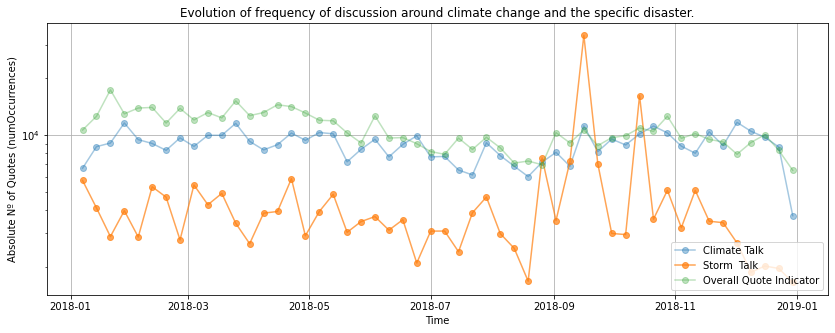

In [19]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       drop_n_last=drop_n_last,
                       save_fig=save_fig)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


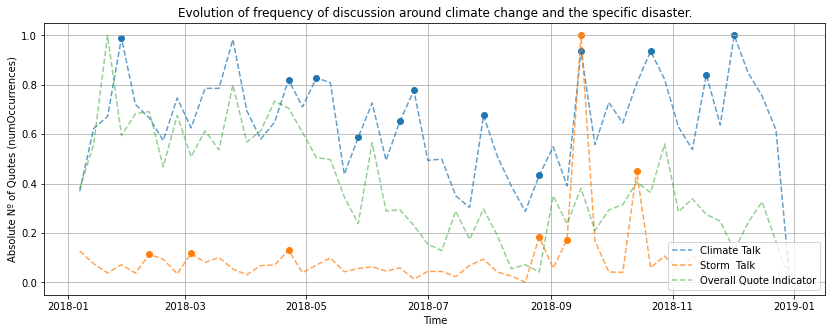

In [20]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             drop_n_last=drop_n_last,
                             specific_general_increase=specific_general_increase,
                             specific_increase=specific_increase,
                             save_fig=save_fig)

**2019**

In [21]:
year = 2019
disaster_type = 'storm'
specific_general_increase = 3.0
specific_increase = 0.03

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


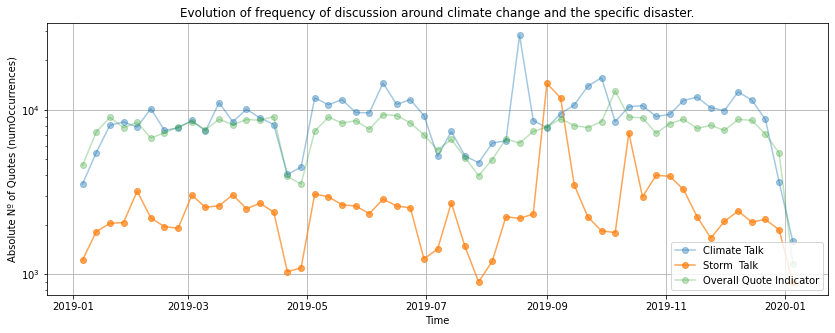

In [22]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W', 
                       normalize=False, 
                       log=True, 
                       norm_additional=True,
                       save_fig=save_fig)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


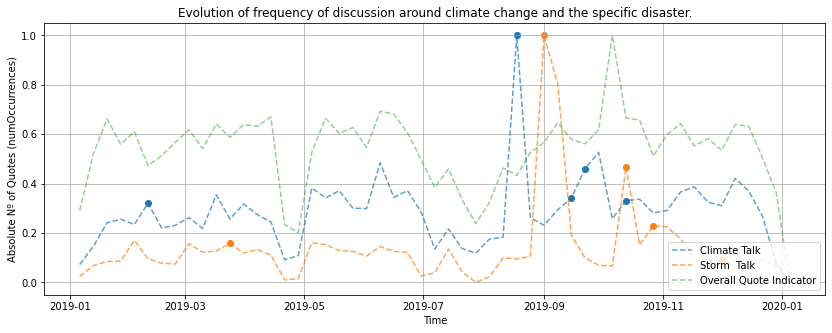

In [23]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             specific_general_increase=specific_general_increase,
                             specific_increase=specific_increase,
                             save_fig=save_fig)

**2020**

In [24]:
year = 2020
disaster_type = 'storm'

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


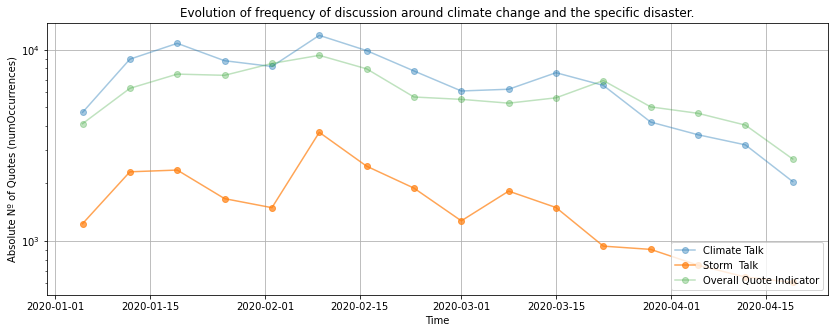

In [25]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       save_fig=save_fig)

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


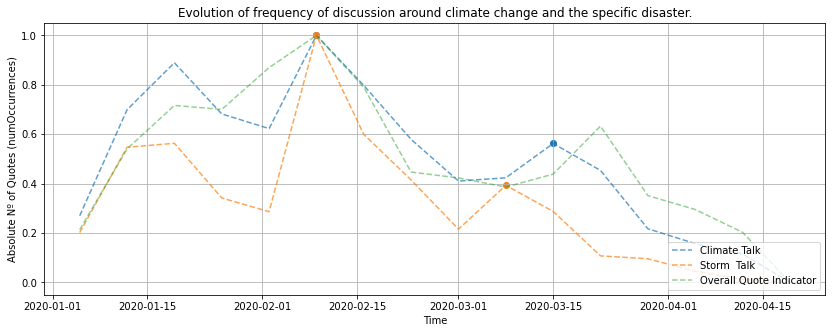

In [26]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             save_fig=save_fig)

### Heat Waves

**2015**

In [27]:
year = 2015
disaster_type = 'heat_wave'

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


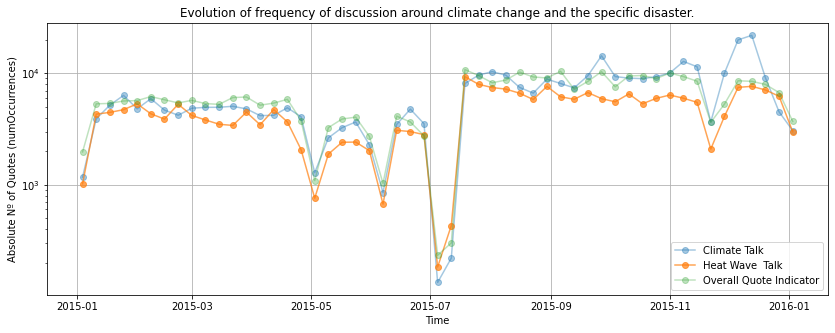

In [28]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       save_fig=save_fig)

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


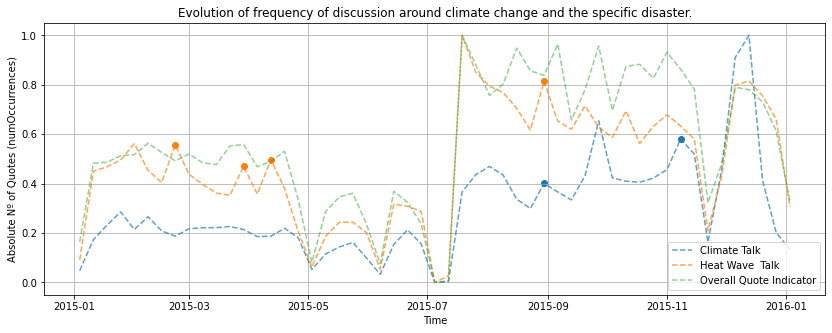

In [29]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             save_fig=save_fig)

**2016**

In [30]:
year = 2016
disaster_type = 'heat_wave'

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


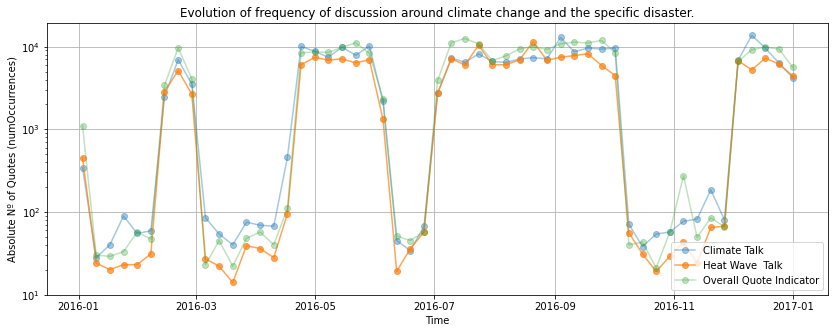

In [31]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W', 
                       normalize=False, 
                       log=True, 
                       norm_additional=True,
                       save_fig=save_fig)

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


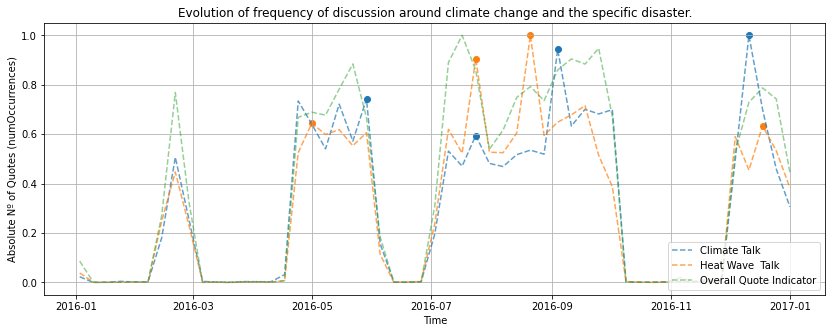

In [32]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             save_fig=save_fig)

**2017**

In [33]:
year = 2017
disaster_type = 'heat_wave'
drop_n_first = 5
specific_general_increase = 2.5
specific_increase = 0.09

Disaster Dates: 2017-01-01 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


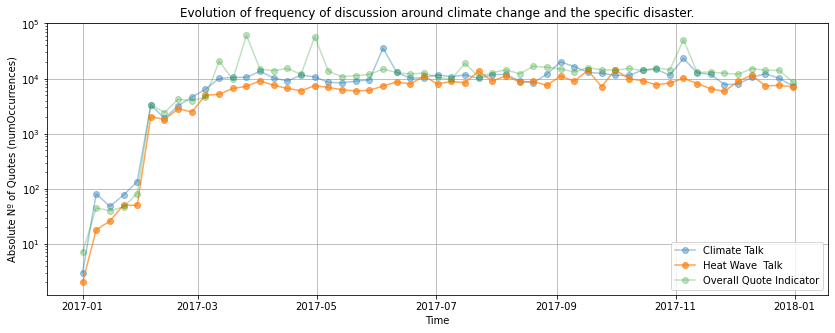

In [34]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W', 
                       normalize=False, 
                       log=True, 
                       norm_additional=True,
                       drop_n_first=0,
                       save_fig=save_fig)

Disaster Dates: 2017-01-01 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


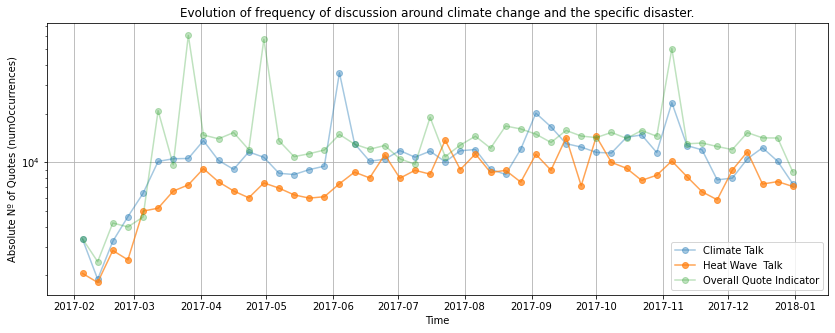

In [35]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W', 
                       normalize=False, 
                       log=True, 
                       norm_additional=True,
                       drop_n_first=drop_n_first,
                       save_fig=save_fig)

Disaster Dates: 2017-01-01 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


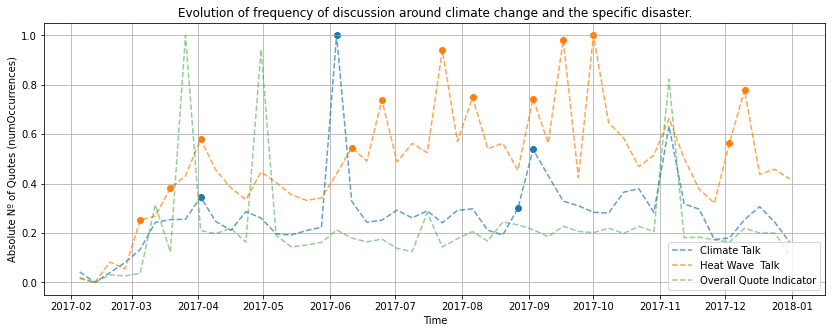

In [36]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             drop_n_first=drop_n_first,
                             specific_general_increase=specific_general_increase,
                             specific_increase=specific_increase,
                             save_fig=save_fig)

**2018**

In [37]:
year = 2018
disaster_type = 'heat_wave'
drop_n_last = 1

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


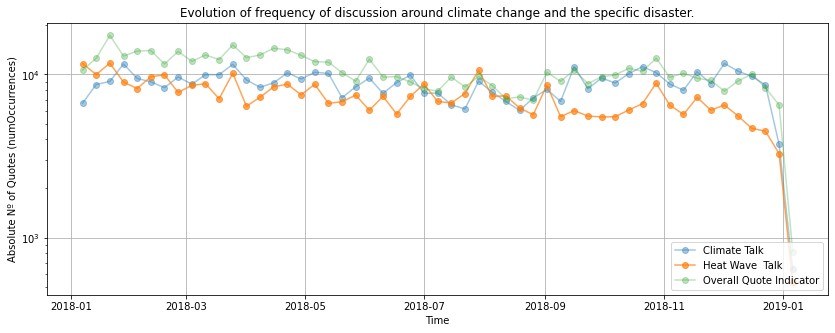

In [38]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       drop_n_last=0,
                       save_fig=save_fig)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


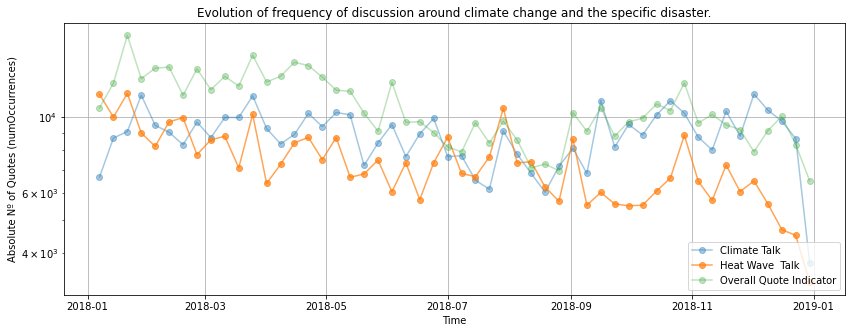

In [39]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       drop_n_last=drop_n_last,
                       save_fig=save_fig)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


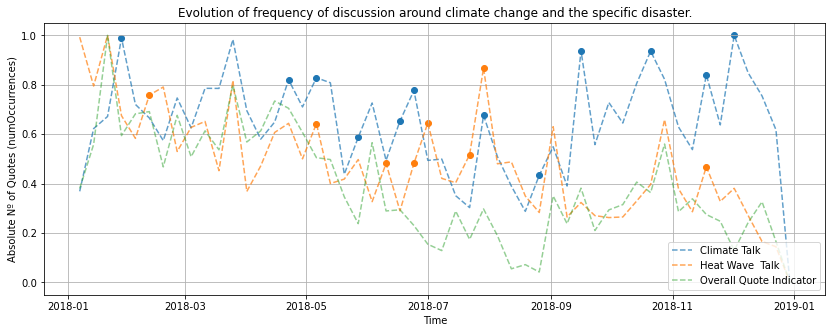

In [40]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             drop_n_last=drop_n_last,
                             save_fig=save_fig)

**2019**

In [41]:
year = 2019
disaster_type = 'heat_wave'
drop_n_last = 1
specific_general_increase = 3.0
specific_increase = 0.03

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


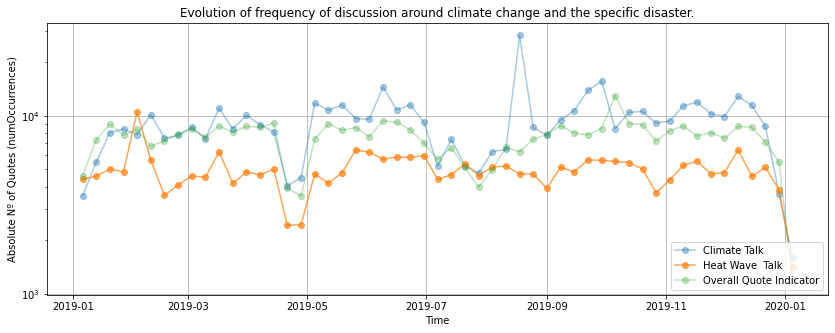

In [42]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W', 
                       normalize=False, 
                       log=True, 
                       norm_additional=True, 
                       drop_n_last=0,
                       save_fig=save_fig)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


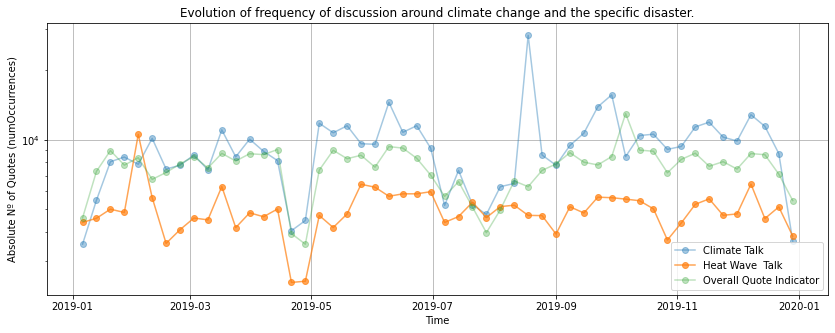

In [43]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W', 
                       normalize=False, 
                       log=True, 
                       norm_additional=True,
                       drop_n_last=drop_n_last,
                       save_fig=save_fig)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


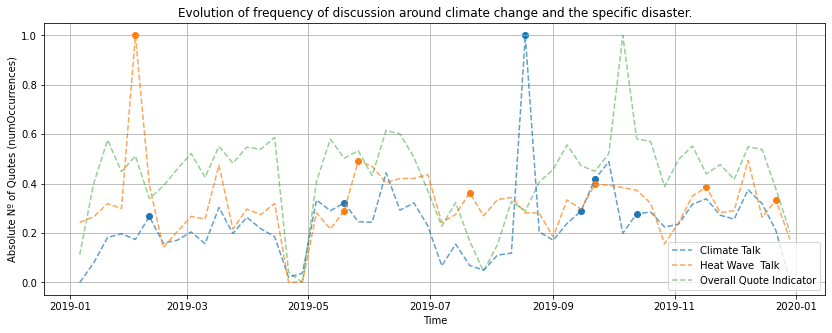

In [44]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             drop_n_last=drop_n_last,
                             specific_general_increase=specific_general_increase,
                             specific_increase=specific_increase,
                             save_fig=save_fig)

**2020**

In [45]:
year = 2020
disaster_type = 'heat_wave'

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


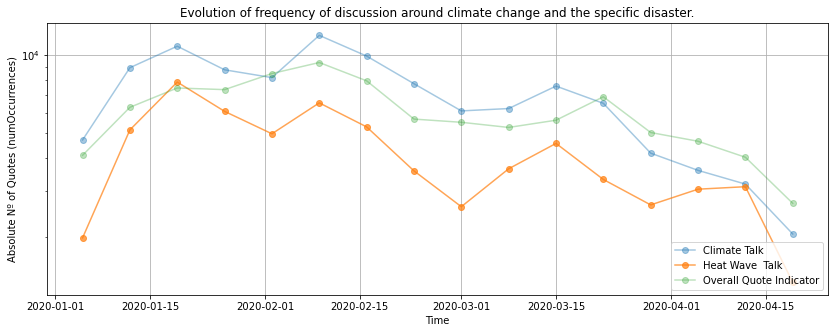

In [46]:
create_plot_comparison(year,
                       disaster_type,
                       general=True,
                       resample='1W',
                       normalize=False,
                       log=True,
                       norm_additional=True,
                       save_fig=save_fig)

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


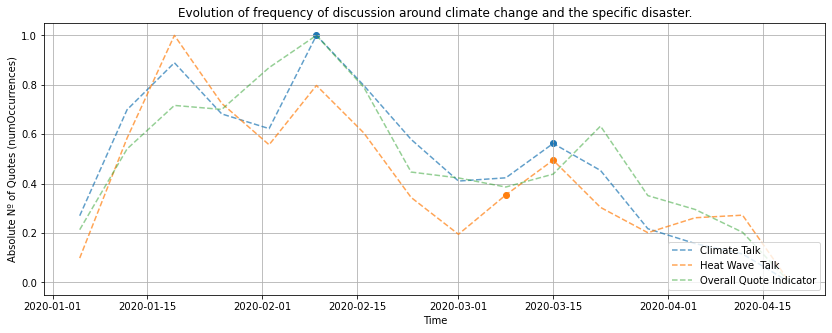

In [47]:
create_normalized_comparison(year,
                             disaster_type,
                             resample='1W',
                             save_fig=save_fig)

## Histogram Plots Of Specific Disasters In Each Year

### Heat Waves

In [161]:
disaster_type = 'heat_wave'

**2015**

Disaster Dates: 2015-05-20 --- 2015-06-09
Climate Dates:  2015-04-29 --- 2015-06-20


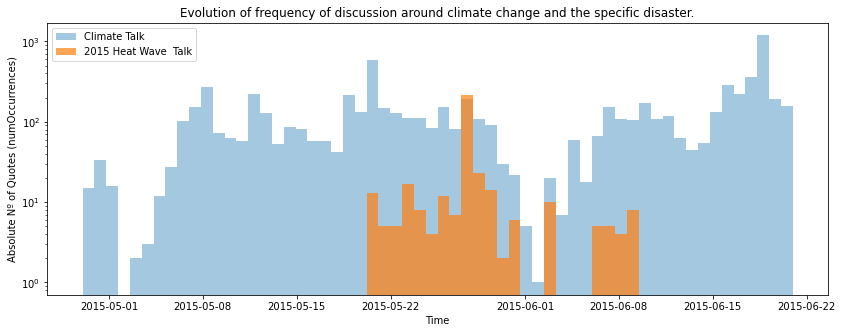

In [162]:
create_hist_comparison(2015,disaster_type)

**2016**

Disaster Dates: 2016-04-17 --- 2016-05-20
Climate Dates:  2016-03-11 --- 2016-05-20


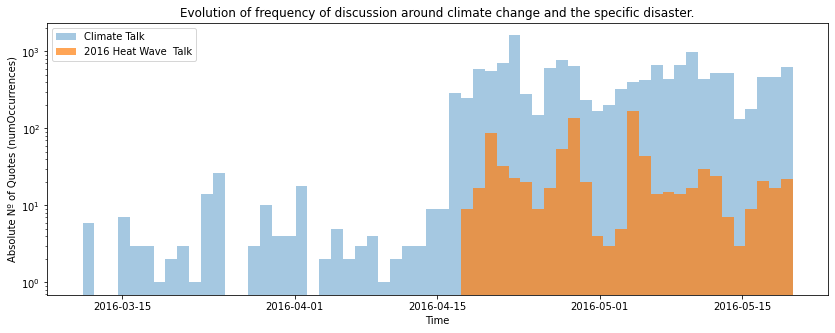

In [155]:
create_hist_comparison(2016,disaster_type)

**2017**

Disaster Dates: 2017-01-31 --- 2017-02-24
Climate Dates:  2017-01-11 --- 2017-03-07


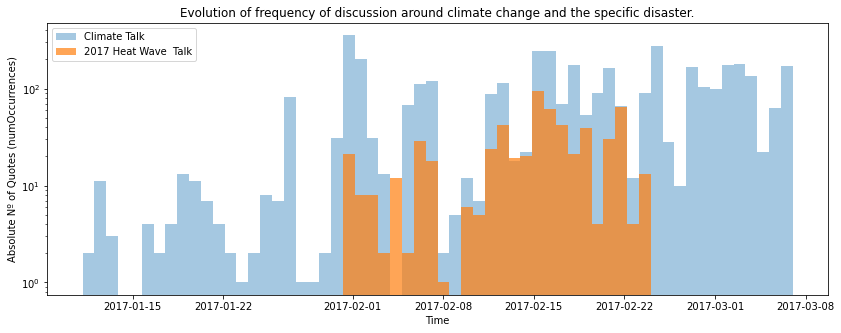

In [156]:
create_hist_comparison(2017,disaster_type)

**2018**

Disaster Dates: 2018-07-01 --- 2018-08-03
Climate Dates:  2018-06-10 --- 2018-08-03


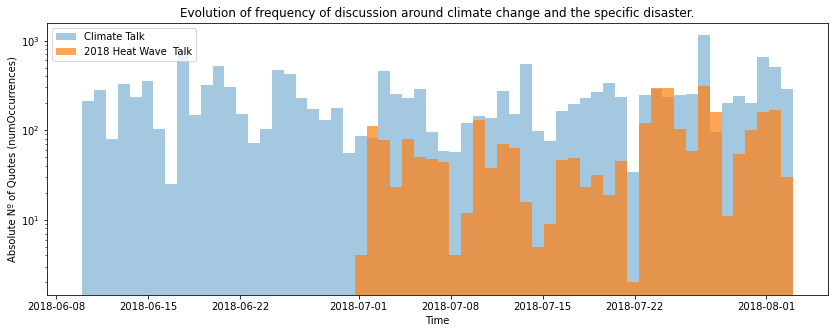

In [157]:
create_hist_comparison(2018,disaster_type)

**2019**

Disaster Dates: 2019-07-19 --- 2019-08-05
Climate Dates:  2019-06-28 --- 2019-08-17


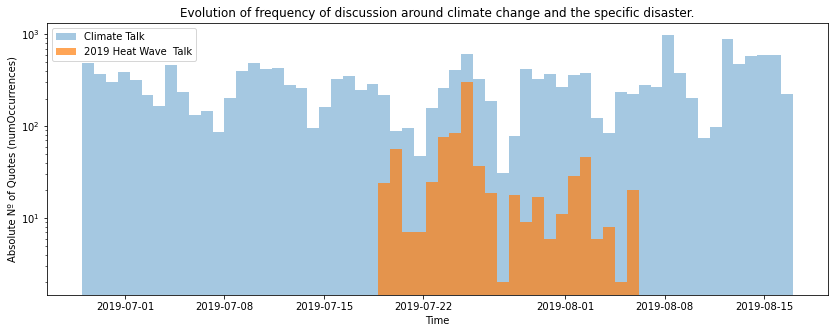

In [158]:
create_hist_comparison(2019,disaster_type)

**2020**

Disaster Dates: 2019-09-02 --- 2020-01-31
Climate Dates:  2019-08-11 --- 2020-02-01


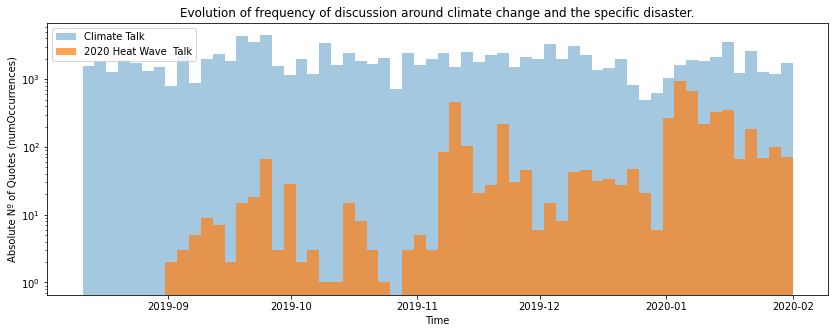

In [135]:
create_hist_comparison(2020,disaster_type)

### Storms

In [136]:
disaster_type = 'storm'

**2015**

Disaster Dates: 2015-10-22 --- 2015-11-06
Climate Dates:  2015-10-01 --- 2015-11-18


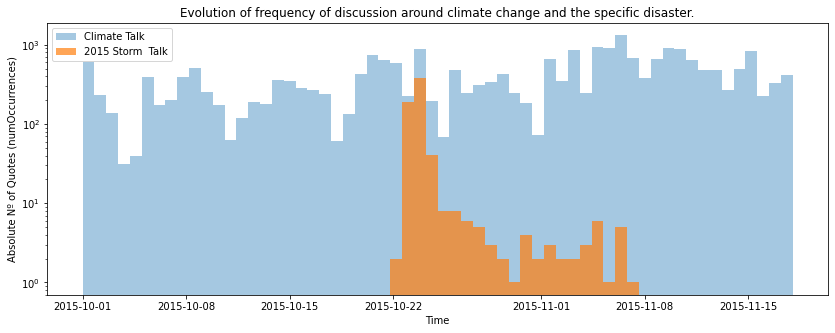

In [137]:
create_hist_comparison(2015,disaster_type)

**2016**

Disaster Dates: 2016-02-18 --- 2016-02-26
Climate Dates:  2016-01-30 --- 2016-03-11


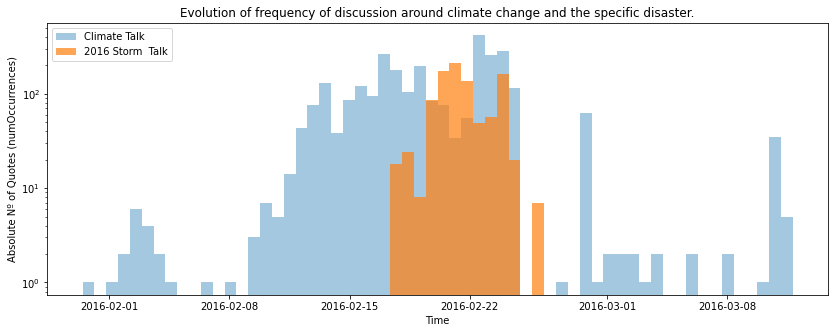

In [138]:
create_hist_comparison(2016,disaster_type)

**2017**

Disaster Dates: 2017-08-23 --- 2017-09-08
Climate Dates:  2017-08-04 --- 2017-09-19


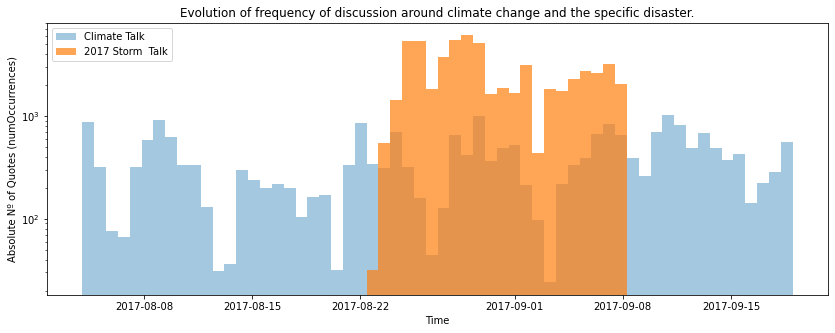

In [139]:
create_hist_comparison(2017,disaster_type)

**2018**

Disaster Dates: 2018-09-08 --- 2018-09-27
Climate Dates:  2018-08-20 --- 2018-10-09


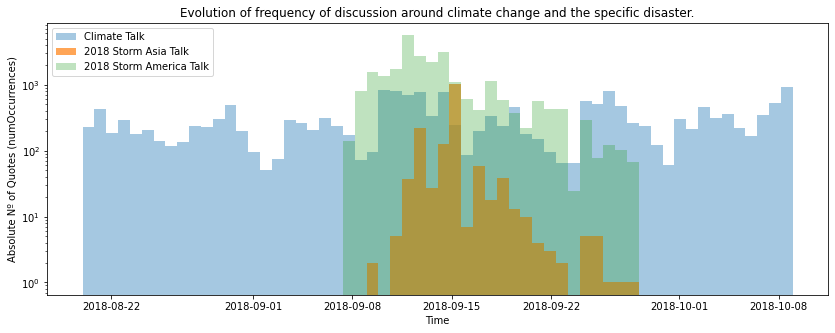

In [140]:
create_hist_comparison(2018,disaster_type)

**2019**

Disaster Dates: 2019-10-07 --- 2019-10-27
Climate Dates:  2019-09-21 --- 2019-11-07


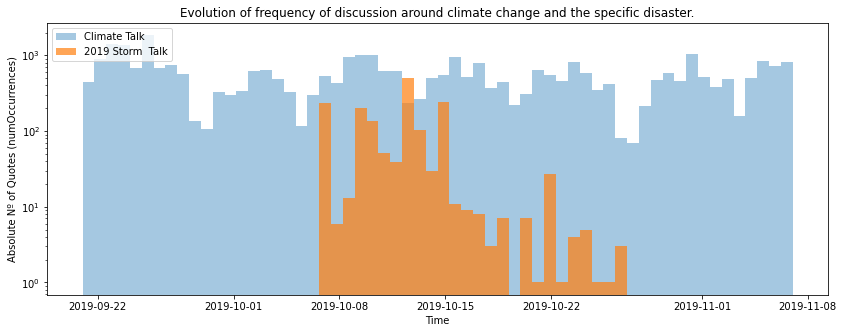

In [141]:
create_hist_comparison(2019,disaster_type)

**2020 (in reality end of 2019)**

Disaster Dates: 2019-12-02 --- 2019-12-12
Climate Dates:  2019-11-11 --- 2019-12-24


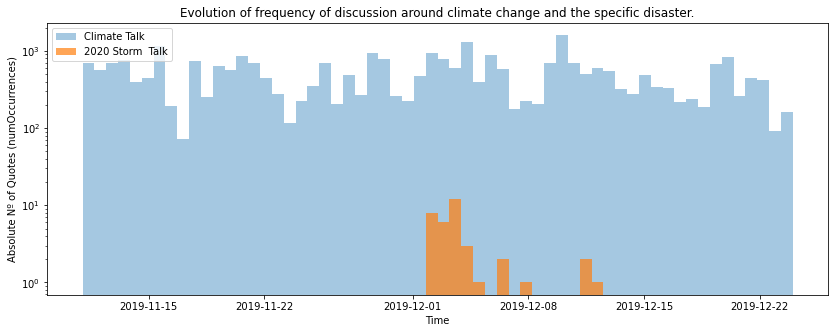

In [142]:
create_hist_comparison(2020,disaster_type)

## Unused

In [206]:
disaster_type = 'heat_wave'

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


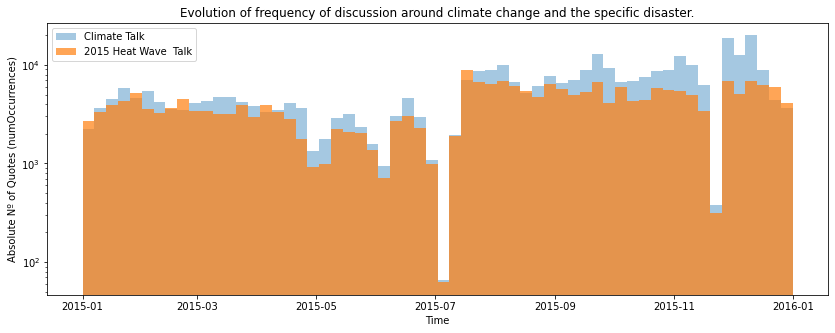

In [211]:
create_hist_comparison(2015,disaster_type,general=True)

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


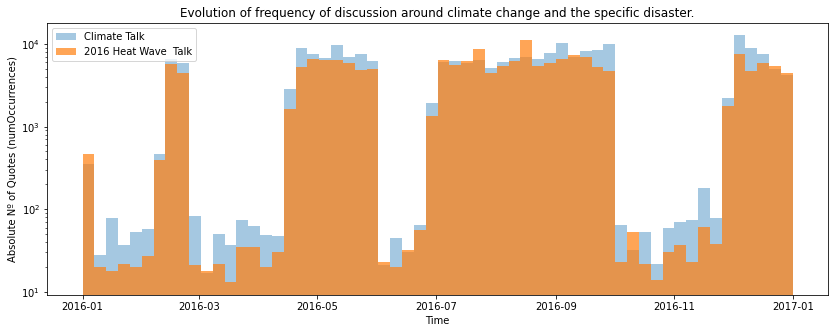

In [212]:
create_hist_comparison(2016,disaster_type,general=True)

Disaster Dates: 2017-01-01 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


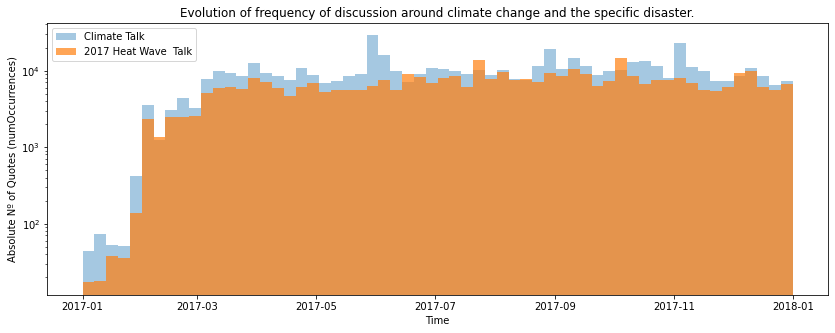

In [213]:
create_hist_comparison(2017,disaster_type,general=True)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


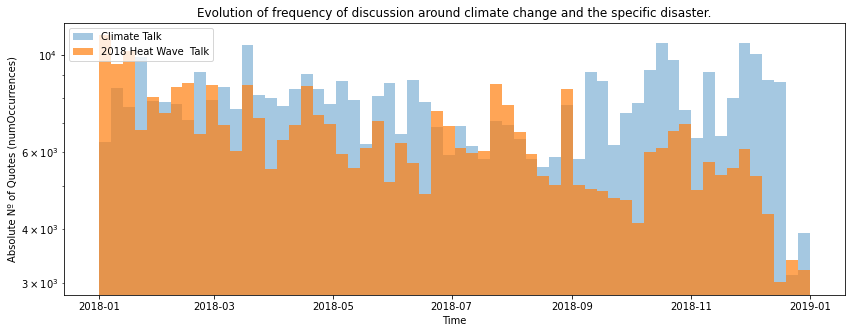

In [214]:
create_hist_comparison(2018,disaster_type,general=True)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


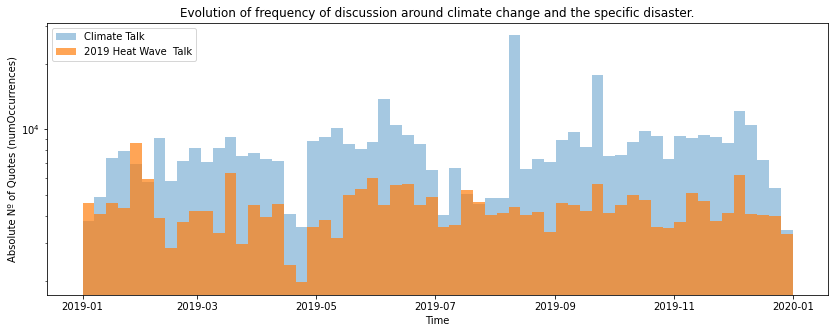

In [215]:
create_hist_comparison(2019,disaster_type,general=True)

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


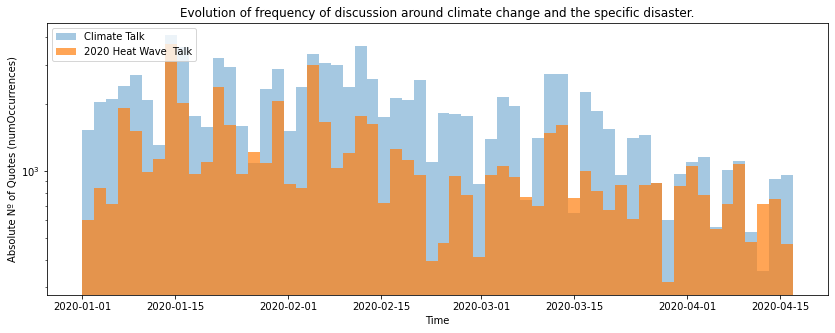

In [216]:
create_hist_comparison(2020,disaster_type,general=True)

In [217]:
disaster_type = 'storm'

Disaster Dates: 2015-01-01 --- 2015-12-31
Climate Dates:  2015-01-01 --- 2015-12-31


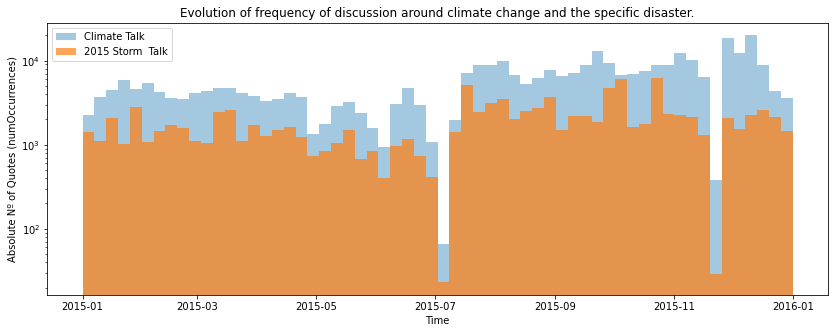

In [218]:
create_hist_comparison(2015,disaster_type,general=True)

Disaster Dates: 2016-01-01 --- 2016-12-31
Climate Dates:  2016-01-01 --- 2016-12-31


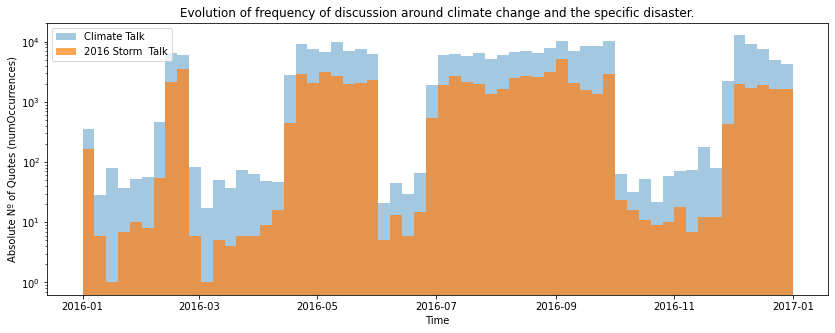

In [219]:
create_hist_comparison(2016,disaster_type,general=True)

Disaster Dates: 2017-01-03 --- 2017-12-31
Climate Dates:  2017-01-01 --- 2017-12-31


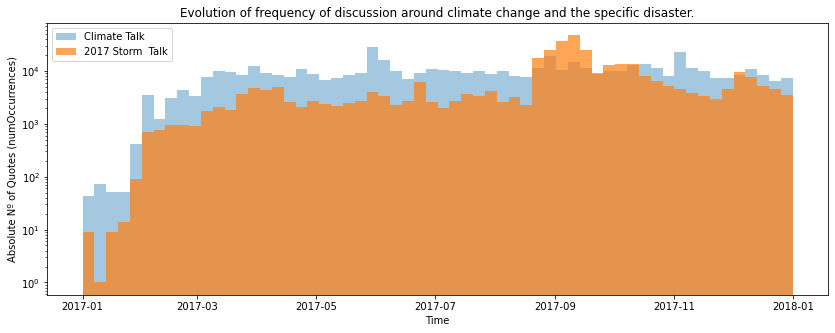

In [220]:
create_hist_comparison(2017,disaster_type,general=True)

Disaster Dates: 2018-01-01 --- 2018-12-31
Climate Dates:  2018-01-01 --- 2018-12-31


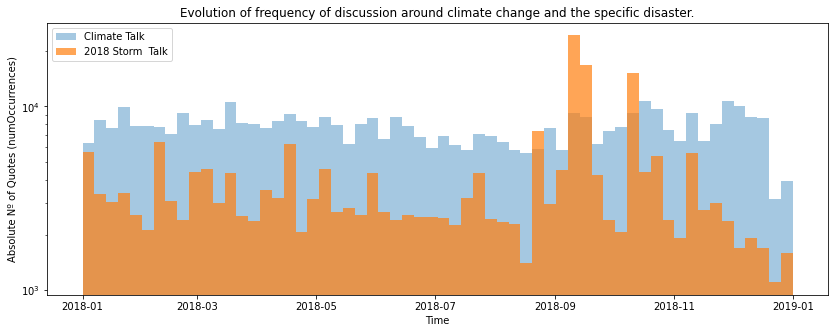

In [221]:
create_hist_comparison(2018,disaster_type,general=True)

Disaster Dates: 2019-01-01 --- 2019-12-31
Climate Dates:  2019-01-01 --- 2019-12-31


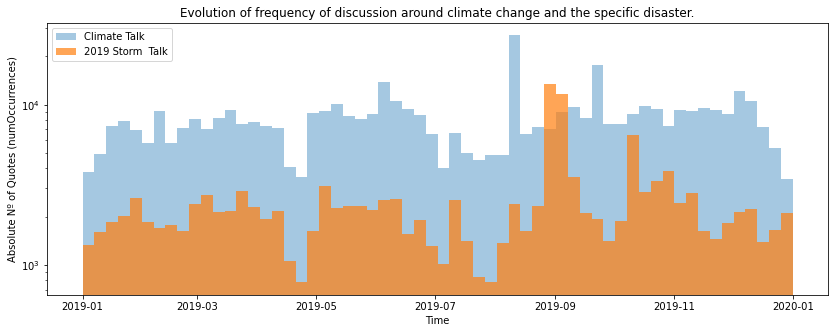

In [222]:
create_hist_comparison(2019,disaster_type,general=True)

Disaster Dates: 2020-01-01 --- 2020-04-17
Climate Dates:  2020-01-01 --- 2020-04-16


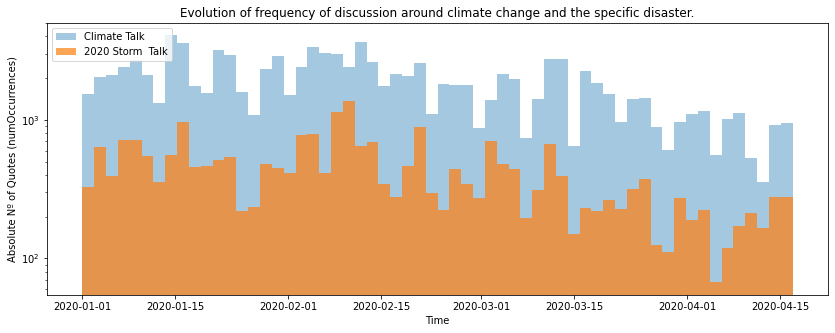

In [223]:
create_hist_comparison(2020,disaster_type,general=True)